In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

In [ ]:
candidate_name = "varun_kumar_parawa"
root = f"ds_{candidate_name}"
os.makedirs(root, exist_ok=True)
os.makedirs(f"{root}/csv_files", exist_ok=True)
os.makedirs(f"{root}/outputs", exist_ok=True)

In [ ]:
fg = pd.read_csv("fear_greed_index.csv")
hist = pd.read_csv("historical_data.csv")

In [ ]:
print("Fear & Greed data:")
display(fg.head())

print("Historical Trades data:")
display(hist.head())

Fear & Greed data:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Historical Trades data:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:
fg['Date'] = pd.to_datetime(fg['date'], errors='coerce').dt.date
fg.rename(columns={'classification': 'Classification'}, inplace=True)

hist['time_parsed'] = pd.to_datetime(hist['Timestamp IST'], errors='coerce')
hist['date'] = hist['time_parsed'].dt.date
hist['size_usd'] = pd.to_numeric(hist['Size USD'], errors='coerce')
hist['closed_pnl'] = pd.to_numeric(hist['Closed PnL'], errors='coerce')

In [ ]:
group = hist.groupby('date')
daily = pd.DataFrame({
    'total_trades': group.size(),
    'total_volume_usd': group['size_usd'].apply(lambda x: x.abs().sum()),
    'avg_closed_pnl': group['closed_pnl'].mean(),
    'win_rate': group['closed_pnl'].apply(lambda x: (x>0).sum()/x.count()),
    'unique_accounts': group['Account'].nunique()
}).reset_index().rename(columns={'date': 'Date'})

print("Daily Aggregates:")
display(daily.head())

Daily Aggregates:


,Date,total_trades,total_volume_usd,avg_closed_pnl,win_rate,unique_accounts
0,2024-01-03,137,472974.70,60.176945,0.934307,1
1,2024-01-04,77,339470.47,32.570953,0.545455,2
2,2024-01-05,14,87025.45,0.000000,0.000000,1
3,2024-01-07,13,97200.55,92.499093,0.692308,1
4,2024-01-08,13,143995.01,0.000000,0.000000,1


In [ ]:
merged = pd.merge(daily, fg[['Date','Classification','value']], on='Date', how='left')
print("Merged with Sentiment:")
display(merged.head())

daily.to_csv(f"{root}/csv_files/daily_aggregates.csv", index=False)
merged.to_csv(f"{root}/csv_files/daily_with_sentiment.csv", index=False)

Merged with Sentiment:


,Date,total_trades,total_volume_usd,avg_closed_pnl,win_rate,unique_accounts,Classification,value
0,2024-01-03,137,472974.70,60.176945,0.934307,1,Greed,70.0
1,2024-01-04,77,339470.47,32.570953,0.545455,2,Greed,68.0
2,2024-01-05,14,87025.45,0.000000,0.000000,1,Greed,72.0
3,2024-01-07,13,97200.55,92.499093,0.692308,1,Greed,71.0
4,2024-01-08,13,143995.01,0.000000,0.000000,1,Greed,71.0


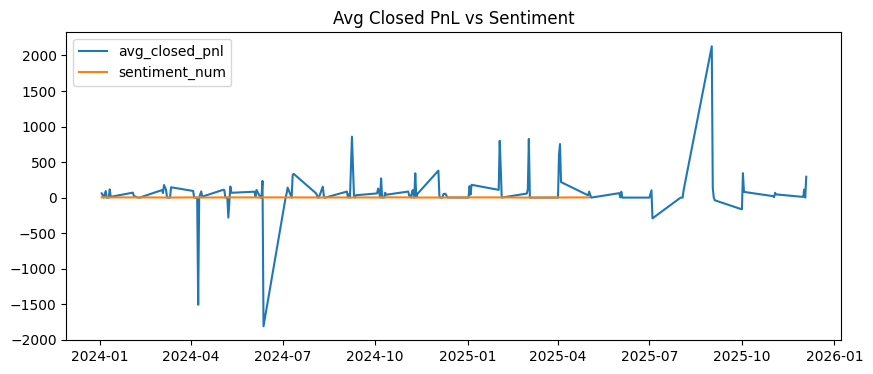

In [ ]:
# Avg PnL vs Sentiment
plt.figure(figsize=(10,4))
plt.plot(merged['Date'], merged['avg_closed_pnl'], label='avg_closed_pnl')
sent_map = {k:i for i,k in enumerate(sorted(merged['Classification'].dropna().unique()))}
merged['sentiment_num'] = merged['Classification'].map(sent_map)
plt.plot(merged['Date'], merged['sentiment_num'], label='sentiment_num')
plt.legend()
plt.title("Avg Closed PnL vs Sentiment")
plt.show()
plt.savefig(f"{root}/outputs/avg_pnl_vs_sentiment.png")
plt.close()

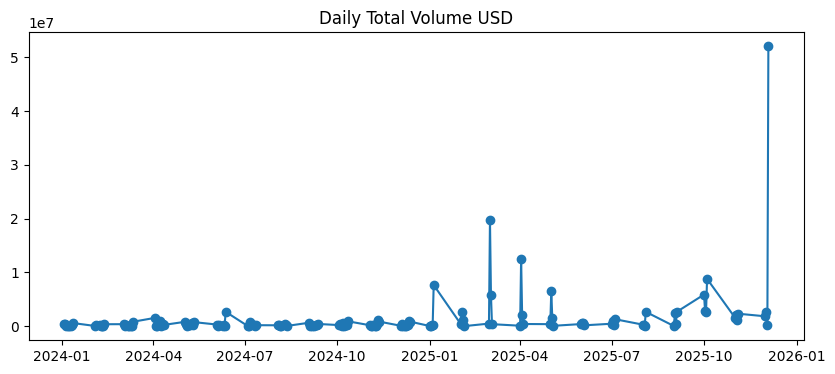

In [ ]:
# Daily Total Volume
plt.figure(figsize=(10,4))
plt.plot(merged['Date'], merged['total_volume_usd'], marker='o')
plt.title("Daily Total Volume USD")
plt.show()
plt.savefig(f"{root}/outputs/daily_total_volume_usd.png")
plt.close()

/tmp/ipython-input-4239110628.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=classes, showfliers=False)


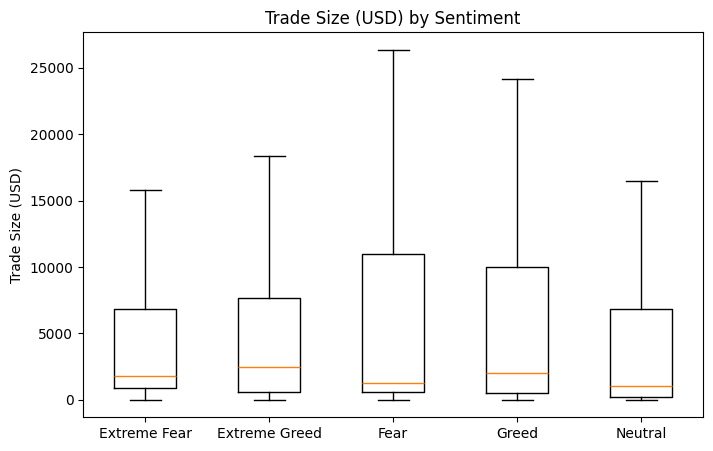

In [ ]:
merged_sizes = hist[['date','size_usd']].merge(
    fg[['Date','Classification']], left_on='date', right_on='Date', how='left'
)
merged_sizes = merged_sizes[
    merged_sizes['Classification'].notnull() & merged_sizes['size_usd'].notnull()
]

if not merged_sizes.empty:
    plt.figure(figsize=(8,5))
    classes = sorted(merged_sizes['Classification'].unique())
    data_to_plot = [merged_sizes[merged_sizes['Classification']==c]['size_usd'] for c in classes]
    plt.boxplot(data_to_plot, labels=classes, showfliers=False)
    plt.title('Trade Size (USD) by Sentiment')
    plt.ylabel('Trade Size (USD)')
    plt.savefig(f"{root}/outputs/trade_size_by_sentiment.png")
    plt.show()